In [ ]:
# En atención a que tengo el dataset en drive, monto el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow opencv-python

In [ ]:
# Importo las librerias necesarias

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import os
import cv2
import joblib
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models

In [ ]:
# Defino la función de normalizar las imágenes, en la que incluyo nuevamente la conversión de las imágenes a escala de grises, por si en el procesado sufrieron cambios por las diferencias en la interpretación del color entre las bibliotecas utilizadas
def normalizar_imagenes(ruta):
    imagen = load_img(ruta)
    imagen = imagen.convert("L")
    imagen_array = img_to_array(imagen)
    imagen_normalizada = imagen_array / 255.0
    return imagen_normalizada

In [ ]:
# Defino la estructura de DenseNet de acuerdo con sus especificaciones originales. Esta estructura fue la que me dio mejores resultados, por su capacidad para procesar y analizar imágenes con gran precisión.
class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.add_module('bn1', nn.BatchNorm2d(in_channels))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, stride=1, bias=False))
        self.add_module('bn2', nn.BatchNorm2d(4 * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False))

class DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = DenseLayer(in_channels + i * growth_rate, growth_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

class TransitionLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.add_module('bn', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, num_classes=2):
        super(DenseNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('bn0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers=num_layers, in_channels=num_features, growth_rate=growth_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionLayer(in_channels=num_features, out_channels=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module('bn5', nn.BatchNorm2d(num_features))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('avgpool5', nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

In [ ]:
# Cargo los datos y verifico sus dimensiones
directorio_guardado = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo'

X_train=joblib.load(os.path.join(directorio_guardado, 'X_train.joblib'))
y_train=joblib.load(os.path.join(directorio_guardado, 'y_train.joblib'))

X_test=joblib.load(os.path.join(directorio_guardado, 'X_test.joblib'))
y_test=joblib.load(os.path.join(directorio_guardado, 'y_test.joblib'))

X_val=joblib.load(os.path.join(directorio_guardado, 'X_val.joblib'))
y_val=joblib.load(os.path.join(directorio_guardado, 'y_val.joblib'))

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_val:", y_val.shape)

Dimensiones de X_train: (1049, 2)
Dimensiones de y_train: (1049,)
Dimensiones de X_test: (350, 2)
Dimensiones de y_test: (350,)
Dimensiones de X_val: (16, 2)
Dimensiones de y_val: (16,)


In [ ]:
# Normalizo las imágenes
ruta_train = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionadas2/train'
ruta_test = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionada2/test'
ruta_val = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionada2/val'

X_train_imgs = np.array([normalizar_imagenes(os.path.join(ruta_train, img)) for img in X_train['Ruta Redimensionada']])
X_test_imgs = np.array([normalizar_imagenes(os.path.join(ruta_test, img)) for img in X_test['Ruta Redimensionada']])
X_val_imgs = np.array([normalizar_imagenes(os.path.join(ruta_val, img)) for img in X_val['Ruta Redimensionada']])

In [ ]:
# Guardo los arrays de las imágenes normalizadas y compruebo que se hayan guardado
ruta_guardado_train = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionadas2/train_imgs.npy'
ruta_guardado_test = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionada2/test_imgs.npy'
ruta_guardado_val = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionada2/val_imgs.npy'

np.save(ruta_guardado_train, X_train_imgs)
np.save(ruta_guardado_test, X_test_imgs)
np.save(ruta_guardado_val, X_val_imgs)

print("Imágenes normalizadas guardadas con éxito.")

Imágenes normalizadas guardadas con éxito.


In [ ]:
# Verifico las dimensiones de los arrays de las imágenes normalizadas
print(f"X_train_imgs: {X_train_imgs.shape}")
print(f"X_test_imgs: {X_test_imgs.shape}")
print(f"X_val_imgs: {X_val_imgs.shape}")

X_train_imgs: (1049, 720, 720, 1)
X_test_imgs: (350, 720, 720, 1)
X_val_imgs: (16, 720, 720, 1)


In [ ]:
# Cargo los arrays de las imágenes normalizadas

ruta_guardado_train = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionadas2/train_imgs.npy'
ruta_guardado_test = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionada2/test_imgs.npy'
ruta_guardado_val = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo/redimensionada2/val_imgs.npy'

X_train_imgs = np.load(ruta_guardado_train)
X_test_imgs = np.load(ruta_guardado_test)
X_val_imgs = np.load(ruta_guardado_val)


In [ ]:
# Cargo y_train, y_test, y_val

directorio_guardado = '/content/drive/MyDrive/Proyecto modulo 7/data_procesada/data_para_modelo'

y_train=joblib.load(os.path.join(directorio_guardado, 'y_train.joblib'))
y_test=joblib.load(os.path.join(directorio_guardado, 'y_test.joblib'))
y_val=joblib.load(os.path.join(directorio_guardado, 'y_val.joblib'))

In [ ]:
# Preparo los datos para el entrenamiento del modelo: elimino dimensiones innecesarias de los datos de imágenes, convierto los datos en tensores (ya que es esto es requerido por el modelo), agrupo los tensores en datasets, creo DataLoaders que crean mini lotes

X_train_imgs = np.squeeze(X_train_imgs, axis=3)
X_test_imgs = np.squeeze(X_test_imgs, axis=3)
X_val_imgs = np.squeeze(X_val_imgs, axis=3)

print(f"Forma de X_train_imgs: {X_train_imgs.shape}")
print(f"Forma de X_test_imgs: {X_test_imgs.shape}")
print(f"Forma de X_val_imgs: {X_val_imgs.shape}")

X_train_tensor = torch.tensor(X_train_imgs, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_imgs, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_imgs, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Forma de X_train_imgs: (1049, 720, 720)
Forma de X_test_imgs: (350, 720, 720)
Forma de X_val_imgs: (16, 720, 720)


In [ ]:
# Defino el modelo DenseNet personalizado, creo el modelo, defino sus hiperparámetros, optimizador, lo entreno y lo evalúo con el conjunto de prueba y validación
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet(x)


model = CustomDenseNet(num_classes=2)


num_epochs = 25
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    total = y_true.size(0)
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_accuracy = 0.0
patience = 5
no_improvement_count = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        inputs = inputs.unsqueeze(1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, labels)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_accuracy / len(train_loader)

    print(f"Época {epoch+1}/{num_epochs}, Pérdida en conjunto de entrenamiento: {epoch_loss:.4f}, Precisión en conjunto de entrenamiento: {epoch_accuracy:.4f}")


    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_total_accuracy = 0.0

        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_inputs = test_inputs.unsqueeze(1)

            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item()
            test_total_accuracy += calculate_accuracy(test_outputs, test_labels)

        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_accuracy = test_total_accuracy / len(test_loader)

        print(f"Época {epoch+1}/{num_epochs}, Pérdida en conjunto de prueba: {test_epoch_loss:.4f}, Precisión en conjunto de prueba: {test_epoch_accuracy:.4f}")


    val_running_loss = 0.0
    val_total_accuracy = 0.0

    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_inputs = val_inputs.unsqueeze(1)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss += val_loss.item()
        val_total_accuracy += calculate_accuracy(val_outputs, val_labels)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_total_accuracy / len(val_loader)

    print(f"Época {epoch+1}/{num_epochs}, Pérdida en conjunto de validación: {val_epoch_loss:.4f}, Precisión en conjunto de validación: {val_epoch_accuracy:.4f}")


    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        torch.save(model.state_dict(), '/content/drive/MyDrive/Proyecto modulo 7/mejor_modelo.pth')
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Parada anticipada en época {epoch+1}')
        break


Época 1/25, Pérdida en conjunto de entrenamiento: 0.2348, Precisión en conjunto de entrenamiento: 0.9044
Época 1/25, Pérdida en conjunto de prueba: 1.8434, Precisión en conjunto de prueba: 0.5682
Época 1/25, Pérdida en conjunto de validación: 2.1704, Precisión en conjunto de validación: 0.5000
Época 2/25, Pérdida en conjunto de entrenamiento: 0.1759, Precisión en conjunto de entrenamiento: 0.9382
Época 2/25, Pérdida en conjunto de prueba: 1.3274, Precisión en conjunto de prueba: 0.4498
Época 2/25, Pérdida en conjunto de validación: 1.3608, Precisión en conjunto de validación: 0.5000
Época 3/25, Pérdida en conjunto de entrenamiento: 0.1293, Precisión en conjunto de entrenamiento: 0.9545
Época 3/25, Pérdida en conjunto de prueba: 2.0998, Precisión en conjunto de prueba: 0.5682
Época 3/25, Pérdida en conjunto de validación: 2.2786, Precisión en conjunto de validación: 0.5000
Época 4/25, Pérdida en conjunto de entrenamiento: 0.1283, Precisión en conjunto de entrenamiento: 0.9621
Época 4/25

In [ ]:
# Guardo las métricas del modelo
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

ruta_guardado_metricas='/content/drive/MyDrive/Proyecto modulo 7/metricas/'
np.save(ruta_guardado_metricas + 'train_losses.npy', np.array(train_losses))
np.save(ruta_guardado_metricas + 'train_accuracies.npy', np.array(train_accuracies))
np.save(ruta_guardado_metricas + 'test_losses.npy', np.array(test_losses))
np.save(ruta_guardado_metricas + 'test_accuracies.npy', np.array(test_accuracies))
np.save(ruta_guardado_metricas + 'val_losses.npy', np.array(val_losses))
np.save(ruta_guardado_metricas + 'val_accuracies.npy', np.array(val_accuracies))


In [ ]:
# Cargo las métricas guardadas y las imprimo

ruta_guardado_metricas = '/content/drive/MyDrive/Proyecto modulo 7/metricas/'

# Cargar las métricas desde archivos .npy
train_losses_loaded = np.load(ruta_guardado_metricas + 'train_losses.npy')
test_losses_loaded = np.load(ruta_guardado_metricas + 'test_losses.npy')
val_losses_loaded = np.load(ruta_guardado_metricas + 'val_losses.npy')
train_accuracies_loaded = np.load(ruta_guardado_metricas + 'train_accuracies.npy')
test_accuracies_loaded = np.load(ruta_guardado_metricas + 'test_accuracies.npy')
val_accuracies_loaded = np.load(ruta_guardado_metricas + 'val_accuracies.npy')

# Imprimir las métricas cargadas
print("Train Losses:", train_losses_loaded)
print("Test Losses:", test_losses_loaded)
print("Validation Losses:", val_losses_loaded)
print("Train Accuracies:", train_accuracies_loaded)
print("Test Accuracies:", test_accuracies_loaded)
print("Validation Accuracies:", val_accuracies_loaded)


Train Losses: [0.2348 0.1759 0.1293 0.1283 0.0887 0.0919 0.0794 0.0866 0.0746]
Test Losses: [1.8434 1.3274 2.0998 0.5837 0.5398 0.5828 1.0735 1.5567 0.7441]
Validation Losses: [2.1704 1.3608 2.2786 0.3691 0.2539 0.5083 0.8023 2.9062 0.6778]
Train Accuracies: [0.9044 0.9382 0.9545 0.9621 0.9678 0.9692 0.9751 0.9694 0.9758]
Test Accuracies: [0.5682 0.4498 0.5682 0.7947 0.8307 0.8415 0.7617 0.6112 0.8729]
Validation Accuracies: [0.5    0.5    0.5    0.875  0.875  0.75   0.6875 0.5    0.75  ]


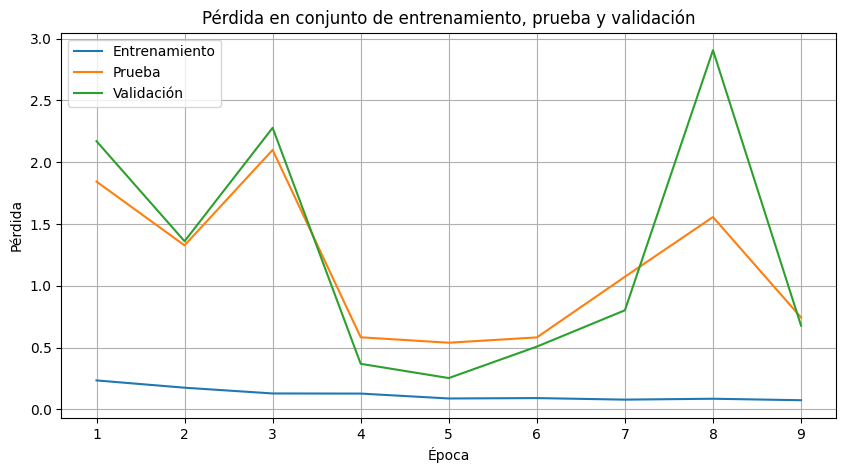

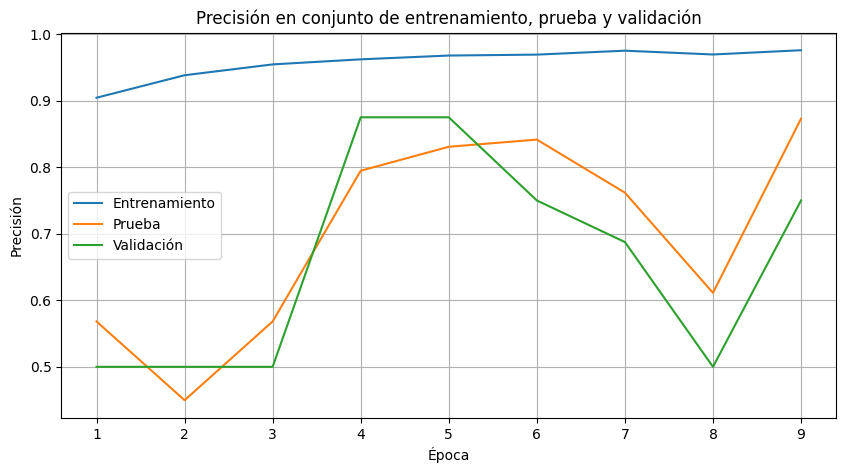

In [ ]:
# Grafico la pérdida y la precisión del conjunto de entrenamiento, prueba y validación en las distintas épocas
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Entrenamiento')
plt.plot(epochs, test_losses, label='Prueba')
plt.plot(epochs, val_losses, label='Validación')
plt.title('Pérdida en conjunto de entrenamiento, prueba y validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Entrenamiento')
plt.plot(epochs, test_accuracies, label='Prueba')
plt.plot(epochs, val_accuracies, label='Validación')
plt.title('Precisión en conjunto de entrenamiento, prueba y validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()
